In [1]:
import requests
import time
import pandas as pd
import numpy as np
headers = {'Content-type': 'content_type_value'}

Getting Reddit API

In [2]:
#query="science" #Define Your Query
#subreddit="worldnews" #Define subreddit if needed

In [3]:
# Range of days to consider for Reddit Comment Search
days_after = [i for i in range(2, 301)]
days_before = [i for i in range(1, 300)]

In [4]:
#Initialize empty lists
comment_list = []
utc_list = []

# Loop through the days we are considering
for da, db in zip(days_after, days_before):
    time.sleep(2)
    url = f"https://api.pushshift.io/reddit/search/comment/?subreddit=worldnews&after={da}d&before={db}d"
    request = requests.get(url, headers=headers)
    json_response = request.json()
    data = json_response['data']
    
    # Append request results to lists
    for comment in data:
        comment_list.append(comment['body'])
        utc_list.append(comment['created_utc'])

In [5]:
len(comment_list)

7425

Creating Dataframe from Reddit's comments

In [165]:
df = pd.DataFrame({"comments": comment_list, "date created": utc_list})

In [168]:
df['date created'] = df['date created'].dt.date
df

,comments,date created
0,They listen VERY VERY CLOSELY.,2020-12-01
1,"Statistically speaking, more people have been ...",2020-12-01
2,Is this unironic?,2020-12-01
3,Maybe people should stop the white nationalist...,2020-12-01
4,"TIL Scotland has 300,000 healthcare workers ou...",2020-12-01
...,...,...
7420,Wtf are you retarded,2020-02-07
7421,Life ain't fair,2020-02-07
7422,I don’t understand the question... the article...,2020-02-07
7423,Tiananmen the Flu could be the mascot,2020-02-07


Sentiment Analysis Using Vader

In [22]:
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/melodyteng/nltk_data...


In [23]:
sia=SIA()

In [176]:
def calculate_polarity_scores(s):
  sia_scores = sia.polarity_scores(s)
  return sia_scores['compound']

df['sia_polarity_scores'] = df['comments'].apply(calculate_polarity_scores) 

In [177]:
df['sia_polarity_scores']

0       0.0000
1      -0.7096
2       0.0000
3      -0.0613
4       0.3612
         ...  
7420   -0.8176
7421   -0.2411
7422    0.7627
7423   -0.3818
7424    0.1449
Name: sia_polarity_scores, Length: 7425, dtype: float64

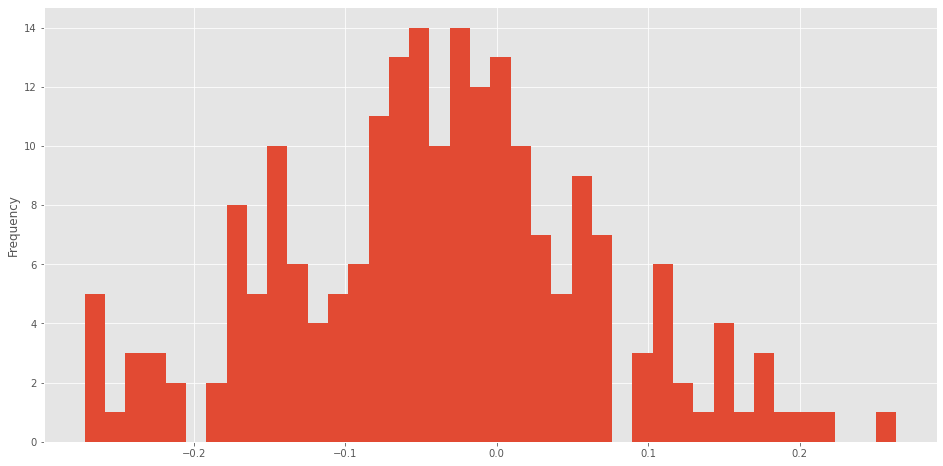

In [306]:
df['sia_polarity_scores'].plot.hist(bins=40)
plt.savefig('Dang, lots of Negativity!') 

In [178]:
df

,comments,date created,sia_polarity_scores
0,They listen VERY VERY CLOSELY.,2020-12-01,0.0000
1,"Statistically speaking, more people have been ...",2020-12-01,-0.7096
2,Is this unironic?,2020-12-01,0.0000
3,Maybe people should stop the white nationalist...,2020-12-01,-0.0613
4,"TIL Scotland has 300,000 healthcare workers ou...",2020-12-01,0.3612
...,...,...,...
7420,Wtf are you retarded,2020-02-07,-0.8176
7421,Life ain't fair,2020-02-07,-0.2411
7422,I don’t understand the question... the article...,2020-02-07,0.7627
7423,Tiananmen the Flu could be the mascot,2020-02-07,-0.3818


Graphing Sentiment Scores as a time series

In [40]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

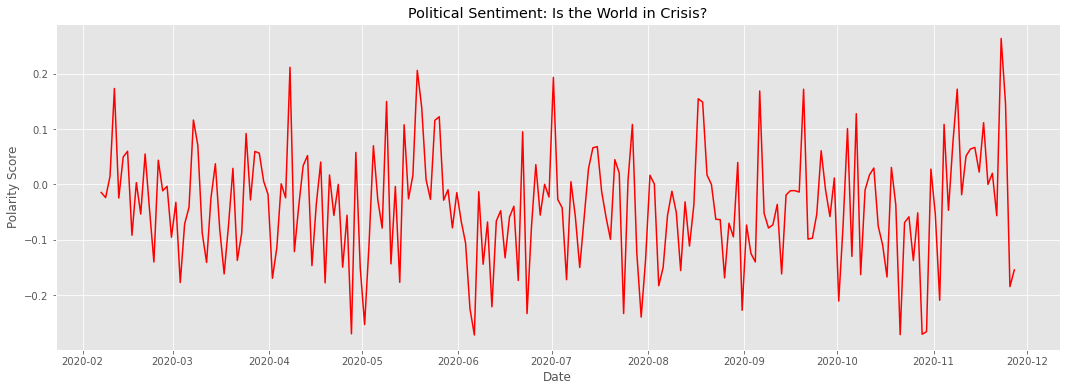

In [303]:
fig, ax = plt.subplots(figsize=(18,6))
x = pd.date_range(start='2020-02-07', end='2020-11-27', periods=209).to_numpy()
ax.plot(x, df['sia_polarity_scores'], color='r', alpha=1)
                       
ax.set_ylabel('Polarity Score')
ax.set_xlabel('Date')
ax.set_title('Political Sentiment: Is the World in Crisis?')
plt.savefig('Are we all going to hell?')

Reading Gold Data and Creating Dataframe

In [224]:
prices = pd.read_csv('Capstone/Gold Daily - Daily.csv', thousands=',')

In [225]:
prices=prices.iloc[10698:,]

In [226]:
prices=prices.drop(prices.columns[2:], axis=1)

In [227]:
prices=prices.rename(columns = {'Name': 'Date'})

In [228]:
prices

,Date,US dollar
10698,1/1/2020,1514.8
10699,1/2/2020,1527.1
10700,1/3/2020,1548.8
10701,1/6/2020,1573.1
10702,1/7/2020,1567.9
...,...,...
10931,11/23/2020,1840.2
10932,11/24/2020,1799.6
10933,11/25/2020,1810.2
10934,11/26/2020,1807.4


In [229]:
prices.dtypes

Date          object
US dollar    float64
dtype: object

In [230]:
prices['Date'] = pd.to_datetime(prices['Date']).dt.date

In [231]:
prices = prices.set_index(['Date'])

In [232]:
prices['US dollar'] 

Date
2020-01-01    1514.8
2020-01-02    1527.1
2020-01-03    1548.8
2020-01-06    1573.1
2020-01-07    1567.9
               ...  
2020-11-23    1840.2
2020-11-24    1799.6
2020-11-25    1810.2
2020-11-26    1807.4
2020-11-27    1779.3
Name: US dollar, Length: 238, dtype: float64

Seasonal Decompostion Analysis

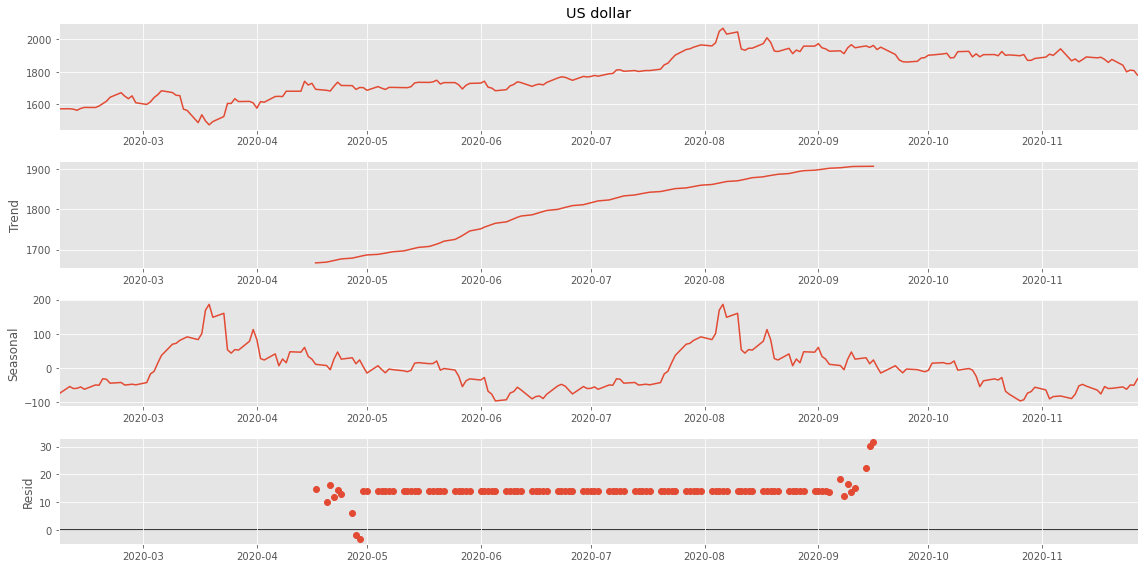

In [326]:
import statsmodels as sm
import statsmodels.api as sm
plt.rc("figure", figsize=(16,8))
decomposition = sm.tsa.seasonal_decompose(prices['US dollar'], model = 'additive', period=100)
fig = decomposition.plot()
plt.savefig('gold seasonal decompose') 
plt.show()


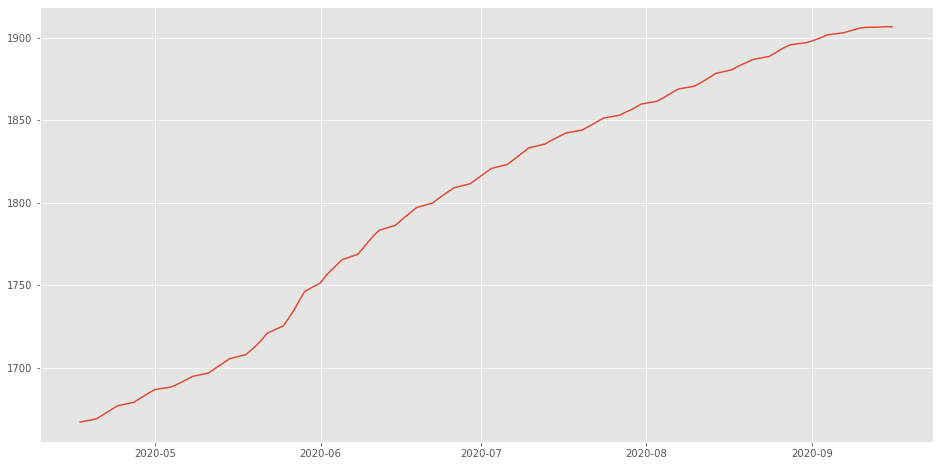

In [340]:
gold_trend=decomposition.trend.plot()
plt.savefig('Gold Prospect') 

Getting a daily average of sentiment score in order to have same date range as gold prices for the merging of two graphs.

In [179]:
df = df.groupby(['date created']).mean()

In [183]:
df

,sia_polarity_scores
date created,
2020-02-07,-0.014676
2020-02-08,-0.054436
2020-02-09,0.011360
2020-02-10,-0.023912
2020-02-11,0.014204
...,...
2020-11-27,-0.154624
2020-11-28,-0.053696
2020-11-29,-0.015932


In [201]:
df.dtypes

sia_polarity_scores    float64
dtype: object

Computing Correlation Coefficient

In [347]:
polarity = df['sia_polarity_scores']

for dollar in prices:
        corr = np.corrcoef(polarity, prices[dollar])
        print('CorrCoef for {} is {}'.format(dollar, str(corr[0][1])))

CorrCoef for US dollar is -0.0427574258947383


Merging the two datasets into one graph.

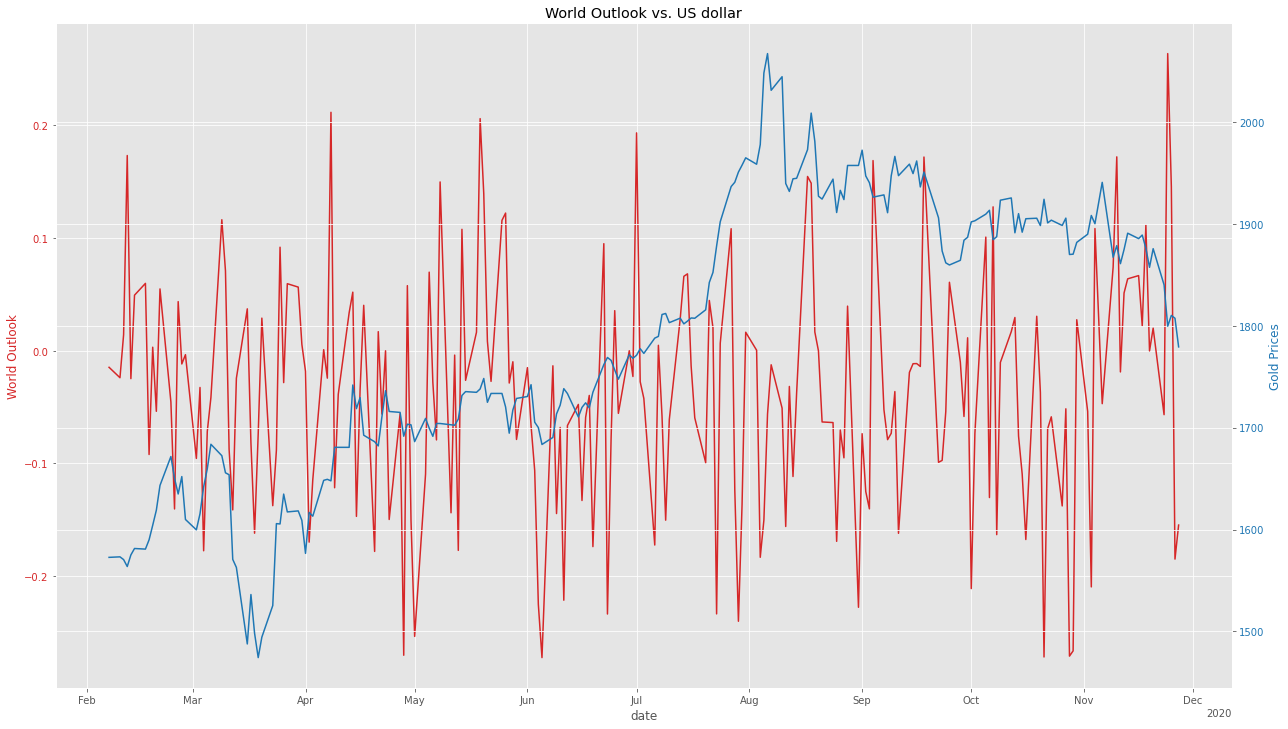

In [325]:
import matplotlib.dates as mdates
months = mdates.MonthLocator()

for dollar in prices:

  fig, ax1 = plt.subplots(figsize=(18, 10))

  color = 'tab:red'
  ax1.set_xlabel('date')
  ax1.set_ylabel('World Outlook', color=color)
  ax1.plot(df.index, polarity, color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  color = 'tab:blue'
  ax2.set_ylabel('Gold Prices', color=color)  # we already handled the x-label with ax1
  ax2.plot(prices.index, prices['US dollar'], color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  locator = mdates.AutoDateLocator()
  formatter = mdates.ConciseDateFormatter(locator)
  ax1.xaxis.set_major_locator(locator)
  ax1.xaxis.set_major_formatter(formatter)
  ax1.xaxis.set_minor_locator(months)
  
  ax1.format_xdata = mdates.DateFormatter('%Y')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.title('World Outlook vs. {}'.format(dollar))
  plt.savefig('We buy gold when we scared')
  plt.show()


In [239]:
#min_date = max(DataFrame.first_valid_index() for DataFrame in [df, prices])
#max_date = min(DataFrame.last_valid_index() for DataFrame in [df, prices])

#df = df[(df.index >= min_date) & (df.index <= max_date)]
#prices = prices[(prices.index >= min_date) & (prices.index <= max_date)]

Fixing index so the two datasets share the same date range as index

In [252]:
df = df.loc[intersect]

In [254]:
prices = prices.loc[intersect]

In [253]:
df

,sia_polarity_scores
2020-02-07,-0.014676
2020-02-10,-0.023912
2020-02-11,0.014204
2020-02-12,0.173184
2020-02-13,-0.024740
...,...
2020-11-23,-0.056700
2020-11-24,0.263588
2020-11-25,0.145500
2020-11-26,-0.184812


In [255]:
prices

,US dollar
2020-02-07,1572.7
2020-02-10,1573.2
2020-02-11,1570.5
2020-02-12,1563.7
2020-02-13,1575.1
...,...
2020-11-23,1840.2
2020-11-24,1799.6
2020-11-25,1810.2
2020-11-26,1807.4


Doing sesonl decomposition analysis on sentiment polairty scores.

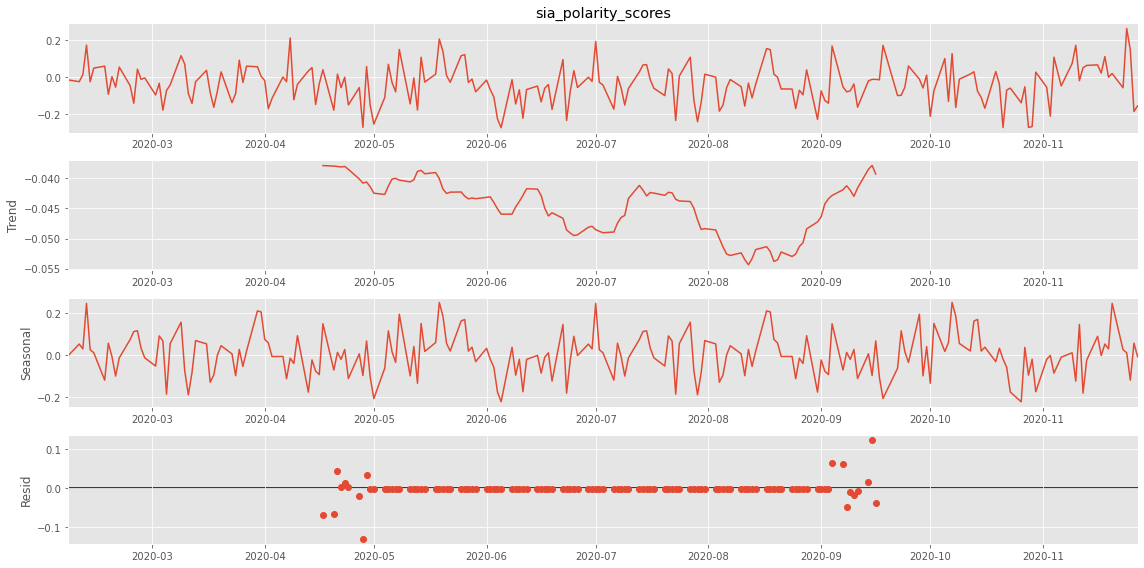

In [356]:
polarity_decomposition = sm.tsa.seasonal_decompose(df['sia_polarity_scores'], model = 'additive', period=100)
fig = polarity_decomposition.plot()
plt.savefig('General Outlook of World')

Showing only the trend.

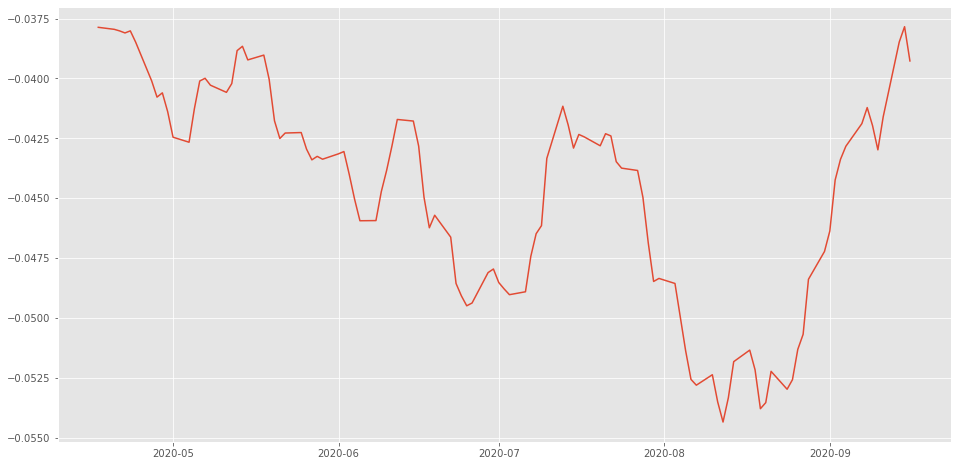

In [357]:
polarity_trend = polarity_decomposition.trend.plot()
plt.savefig('sia_trend')

Merging the gold trend and sentiment trend onto the same graph.

In [352]:
score_trend = polarity_decomposition.trend

In [354]:
gold_prices_trend = decomposition.trend

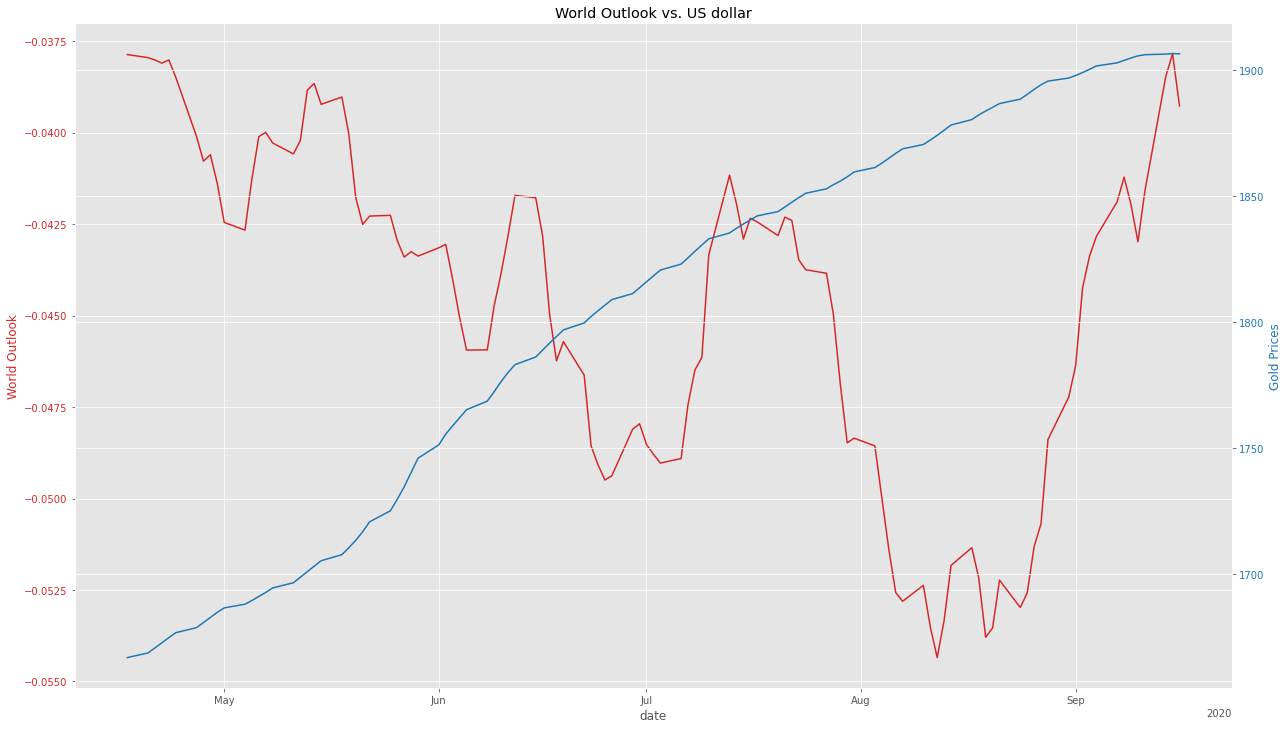

In [358]:
  fig, ax1 = plt.subplots(figsize=(18, 10))

  color = 'tab:red'
  ax1.set_xlabel('date')
  ax1.set_ylabel('World Outlook', color=color)
  ax1.plot(score_trend, color)
  ax1.tick_params(axis='y', labelcolor=color)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
  color = 'tab:blue'
  ax2.set_ylabel('Gold Prices', color=color)  # we already handled the x-label with ax1
  ax2.plot(gold_prices_trend, color)
  ax2.tick_params(axis='y', labelcolor=color)

  locator = mdates.AutoDateLocator()
  formatter = mdates.ConciseDateFormatter(locator)
  ax1.xaxis.set_major_locator(locator)
  ax1.xaxis.set_major_formatter(formatter)
  ax1.xaxis.set_minor_locator(months)
  
  ax1.format_xdata = mdates.DateFormatter('%Y')

  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  plt.title('World Outlook vs. {}'.format(dollar))
  plt.savefig('World Outlook vs Gold Prices')
  plt.show()


Merging Gold Prices and Sentiment Scores into one DataFrame in order to do a linear regression fit.

In [385]:
result = df.join(prices)
result

,sia_polarity_scores,US dollar
2020-02-07,-0.014676,1572.7
2020-02-10,-0.023912,1573.2
2020-02-11,0.014204,1570.5
2020-02-12,0.173184,1563.7
2020-02-13,-0.024740,1575.1
...,...,...
2020-11-23,-0.056700,1840.2
2020-11-24,0.263588,1799.6
2020-11-25,0.145500,1810.2
2020-11-26,-0.184812,1807.4


In [374]:
import seaborn as sns
import matplotlib.pyplot as plt

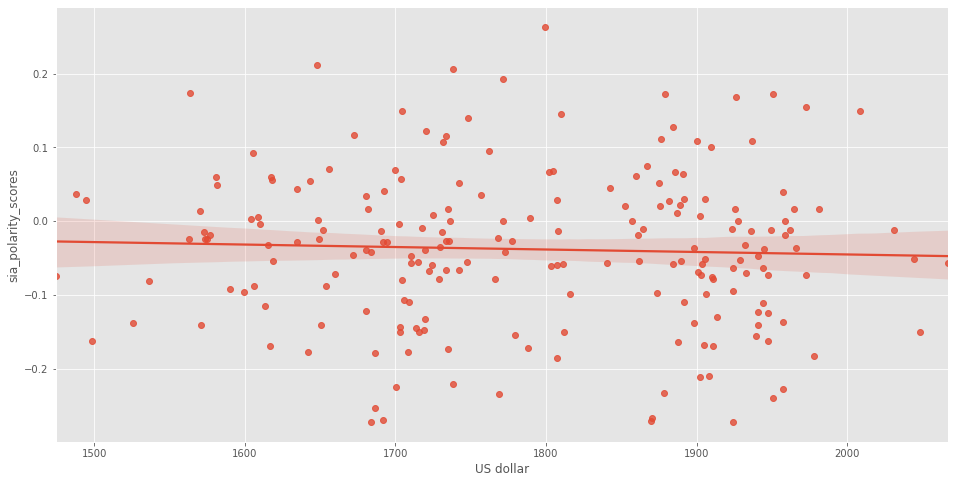

In [388]:
ax = sns.regplot(x="US dollar", y="sia_polarity_scores", data=result)
plt.savefig('corr')